## Tom Brady tracking data release Python introduction

##### By Will Morgan, Head of AMF Data Science, StatsBomb

Below we've included some sample code to you started on loading a game of data and animate a play. Documentation for the dataset can be found [here](https://github.com/statsbomb/amf-open-data/tree/main/doc).

First we'll import the required libraries - you'll need to install these to your local Python environment before you begin if running locally.

In [ ]:
from typing import Literal

import gzip
import json
from requests import get

from IPython.display import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We'll want to create a gif later, which requires a little extra work to install as we'll be using a non-standard library.

In [ ]:
!pip install gif

In [ ]:
import gif

In [ ]:
pd.set_option('display.max_columns', None)

Below we load a game of tracking data direct from the [open data repository](https://github.com/statsbomb/amf-open-data). It's Brady's left ever game (for now) when the Buccaneers lost to the Cowboys in the 2022 Wild Card round.

The files are stored as compressed (gzip) json files, so we use the `gzip` libary to unzip them as part of the loading step.

N.B. We're loading the files direct from the url here using the `requests` library. Alternative code for loading from a local file is included as an example also.

In [ ]:
url = "https://raw.githubusercontent.com/statsbomb/amf-open-data/main/data/tracking/SB_tracking_20230116_DAL_TB.json.gz"
sb_tracking = json.loads(gzip.decompress(get(url).content))

# local_file = "<PATH_TO_FILE>/SB_tracking_20230116_DAL_TB.json.gz"
# with gzip.open(local_file, "r") as f:
#     sb_tracking = json.loads(f.read().decode("utf-8"))

There are several meta-data components in the file given in the keys in the below cell. What we're most interested in here though is the `plays` object which contains the tracking data.

In [ ]:
sb_tracking.keys()

dict_keys(['game_id', 'nfl_game_id', 'nfl_old_game_id', 'competition_name', 'competition_id', 'season_name', 'season_id', 'game_date', 'home_team', 'away_team', 'frequency', 'units', 'plays'])

Here we convert the `plays` object into a Pandas dataframe so that we can do some basic plotting.

In [ ]:
tracks = pd.json_normalize(
    sb_tracking,
    ["plays", "tracks", "steps"],
    meta=[
        "game_id",
        ["plays", "play_uuid"],
        ["plays", "start_timestamp"],
        ["plays", "end_timestamp"],
        ["plays", "play_offense_team_id"],
        ["plays", "offense_left_to_right"],
        ["plays", "calibration_fault_ratio"],
        ["plays", "tracks", "nfl_team_id"],
        ["plays", "tracks", "team_id"],
        ["plays", "tracks", "player", "player_id"],
        ["plays", "tracks", "player", "name"],
        ["plays", "tracks", "player", "jersey_number"],
        ["plays", "tracks", "player", "position_code"],
        ["plays", "tracks", "on_camera_ratio"],
    ],
)
tracks.columns = [x.split(".")[-1] for x in tracks.columns]

In [ ]:
tracks["frame_index"] = tracks.groupby("play_uuid")["time_since_snap"].rank("dense") - 1 # added for convenience later

In [ ]:
tracks.head()

,timestamp,x,y,ngs_x,ngs_y,time_since_snap,calibration_fault,game_id,play_uuid,start_timestamp,end_timestamp,play_offense_team_id,offense_left_to_right,calibration_fault_ratio,nfl_team_id,team_id,player_id,name,jersey_number,position_code,on_camera_ratio,frame_index
0,24866666,73.86,32.38,533.16,224.28,-4.755,NaN,1501351,e256893a-374b-46e6-807b-3c6f153b205a,24871478,34465056,1001367,False,0.0,TB,1000947,1024519,Anthony Nelson,98,LB,1.0,0.0
1,24900000,73.87,32.38,533.22,224.28,-4.721,NaN,1501351,e256893a-374b-46e6-807b-3c6f153b205a,24871478,34465056,1001367,False,0.0,TB,1000947,1024519,Anthony Nelson,98,LB,1.0,1.0
2,24933333,73.88,32.38,533.28,224.28,-4.688,NaN,1501351,e256893a-374b-46e6-807b-3c6f153b205a,24871478,34465056,1001367,False,0.0,TB,1000947,1024519,Anthony Nelson,98,LB,1.0,2.0
3,24966666,73.89,32.38,533.34,224.28,-4.655,NaN,1501351,e256893a-374b-46e6-807b-3c6f153b205a,24871478,34465056,1001367,False,0.0,TB,1000947,1024519,Anthony Nelson,98,LB,1.0,3.0
4,25000000,73.90,32.37,533.40,224.22,-4.621,NaN,1501351,e256893a-374b-46e6-807b-3c6f153b205a,24871478,34465056,1001367,False,0.0,TB,1000947,1024519,Anthony Nelson,98,LB,1.0,4.0


The following is a helper function to plot a field on an existing axis. There are options for the orientation of the field to be plotted, whether to use NFL or NCAA hash markings, colors and how to annotate yardlines.

In [ ]:
X_MIN = -10
X_MAX = 110
Y_MIN = 0
Y_MAX = 160 / 3
Y_MID = (Y_MAX - Y_MIN) / 2

GOAL_WIDTH = 6.166667  # 18 feet 6 inches
LHS_POST = Y_MID - (GOAL_WIDTH / 2)
RHS_POST = Y_MID + (GOAL_WIDTH / 2)
CROSSBAR = 3.3  # 10 feet
POST_HEIGHT = 11.6667  # 35 feet

NFL_HASH = 23.583333  # 70 feet 9 inches
NCAA_HASH = 20.0  # 60 feet


def field(
    ax: plt.axes,
    orientation: Literal["horizontal", "vertical"],
    level: Literal["NFL", "NCAA"],
    background_color: str = "#F2F2F2",
    patch_color: str = "#CCCCCC",
    line_color: str = "#999999",
    normalise_los: bool = False,
) -> plt.axes:

    hash_mark = NCAA_HASH if level == "NCAA" else NFL_HASH
    hash_left = hash_mark
    hash_right = Y_MAX - hash_mark

    x_extent = [X_MIN, X_MIN, X_MIN, X_MAX, X_MAX, X_MAX, X_MAX, X_MIN]
    y_extent = [Y_MIN, Y_MAX, Y_MIN, Y_MIN, Y_MAX, Y_MAX, Y_MAX, Y_MAX]

    ax.plot(
        x_extent if orientation == "horizontal" else y_extent,
        y_extent if orientation == "horizontal" else x_extent,
        color=line_color,
        lw=1,
    )

    for b in [0.0, 100.0]:
        ax.plot(
            [b, b] if orientation == "horizontal" else [Y_MIN, Y_MAX],
            [Y_MIN, Y_MAX] if orientation == "horizontal" else [b, b],
            color=line_color,
            lw=1,
            zorder=1,
        )

    canvas = patches.Rectangle(
        (0, 0),
        100 if orientation == "horizontal" else Y_MAX,
        Y_MAX if orientation == "horizontal" else 100,
        linewidth=0.1,
        edgecolor=line_color,
        facecolor=background_color,
        zorder=0,
    )
    ax.add_patch(canvas)

    for n, line in enumerate(np.arange(0.0, 100.0, 10)):
        ax.plot(
            [line, line] if orientation == "horizontal" else [Y_MIN, Y_MAX],
            [Y_MIN, Y_MAX] if orientation == "horizontal" else [line, line],
            color=line_color,
            zorder=1,
            alpha=0.5,
        )
        if n % 2 == 0:
            patch = patches.Rectangle(
                (line, Y_MIN) if orientation == "horizontal" else (Y_MIN, line),
                10 if orientation == "horizontal" else Y_MAX,
                Y_MAX if orientation == "horizontal" else 10,
                linewidth=0.1,
                edgecolor=line_color,
                facecolor=patch_color,
                zorder=1,
            )
            ax.add_patch(patch)

    for dash_line in np.arange(5.0, 100.0, 5):
        ax.plot(
            [dash_line, dash_line] if orientation == "horizontal" else [Y_MIN, Y_MAX],
            [Y_MIN, Y_MAX] if orientation == "horizontal" else [dash_line, dash_line],
            ls="--",
            color=line_color,
            lw=1.0,
            alpha=0.5,
            zorder=1,
        )

    for x in np.linspace(1, 99, 99):
        ax.plot(
            [x, x] if orientation == "horizontal" else [Y_MIN, 0.7],
            [Y_MIN, 0.7] if orientation == "horizontal" else [x, x],
            color=line_color,
            lw=1.0,
            alpha=0.5,
            zorder=1,
        )
        ax.plot(
            [x, x] if orientation == "horizontal" else [Y_MAX, Y_MAX - 0.7],
            [Y_MAX, Y_MAX - 0.7] if orientation == "horizontal" else [x, x],
            color=line_color,
            lw=1.0,
            alpha=0.5,
            zorder=1,
        )
        ax.plot(
            [x, x] if orientation == "horizontal" else [hash_left, hash_left - 0.7],
            [hash_left, hash_left - 0.7] if orientation == "horizontal" else [x, x],
            color=line_color,
            lw=1.0,
            alpha=0.5,
            zorder=1,
        )
        ax.plot(
            [x, x] if orientation == "horizontal" else [hash_right, hash_right + 0.7],
            [hash_right, hash_right + 0.7] if orientation == "horizontal" else [x, x],
            color=line_color,
            lw=1.0,
            alpha=0.5,
            zorder=1,
        )

    coords = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    values = (
        ["10", "20", "30", "40", "50", "40", "30", "20", "10"]
        if normalise_los is False
        else ["-10", "LOS", "10", "20", "30", "40", "50", "60", "70"]
    )
    for x, v in zip(coords, values):
        ax.annotate(
            v,
            (x, Y_MAX + 1.5) if orientation == "horizontal" else (Y_MAX + 2, x),
            ha="center",
            va="center",
            color=line_color,
        )
        ax.annotate(
            v,
            (x, Y_MIN - 1.5) if orientation == "horizontal" else (Y_MIN - 2, x),
            ha="center",
            va="center",
            color=line_color,
        )

    x_lim = -11, 111
    y_lim = Y_MAX + 1, - 1

    ax.set_xlim(x_lim if orientation == "horizontal" else y_lim)
    ax.set_ylim(y_lim if orientation == "horizontal" else x_lim)

    ax.axis("off")

    return ax

We also want a couple of functions to help plot individual frames within a play and the full tracks over a given play.

In [ ]:
def frame_plot(
    frame: pd.DataFrame,
    ax: plt.axes,
    offense_color: str,
    defense_color: str,
    ) -> plt.axes:
    for (offense, team, jersey), player_frame in frame.groupby(["play_offense_team_id", "team_id", "jersey_number"]):
        ax.plot(
            player_frame["x"],
            player_frame["y"],
            "o",
            markersize=15,
            color=offense_color if team == offense else defense_color
        )
        ax.annotate(
            str(jersey),
            (
                player_frame.iloc[0]["x"],
                player_frame.iloc[0]["y"]
                ),
            ha="center",
            va="center",
            color="w",
        )

    return ax


def play_plotter(
    frames: pd.DataFrame,
    frame_index: int,
    offense_color: str = "#e21017",
    defense_color: str = "#4ACBCE",
    ) -> plt.figure:
    fig, ax = plt.subplots(figsize=(12, 5.3))

    field(ax, orientation="horizontal", level="NFL", normalise_los=False)

    for (offense, team, _), player_tracks in frames.groupby(["play_offense_team_id", "team_id", "player_id"]):
        ax.plot(
            player_tracks["x"],
            player_tracks["y"],
            color=offense_color if team == offense else defense_color
        )

    frame_plot(frames.query(f"frame_index == {frame_index}"), ax, offense_color, defense_color)

    return fig

Let's take a look at the last touchdown pass of Brady's career, caught by #84 Cameron Brate.

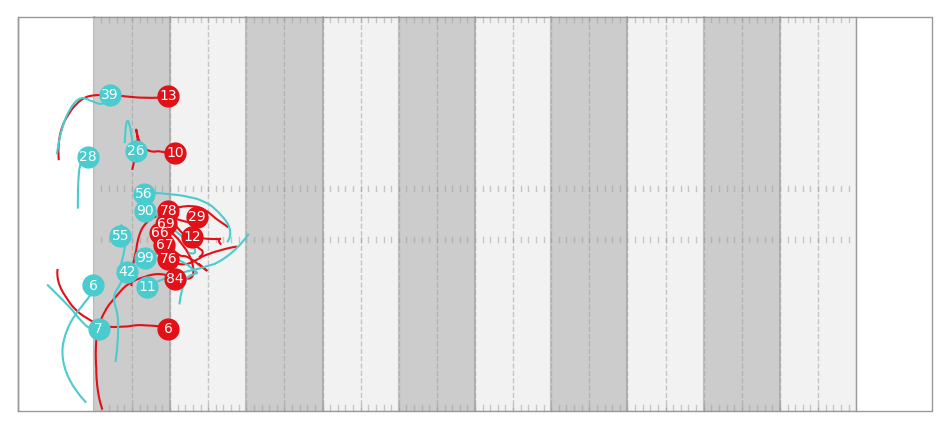

In [ ]:
play_uuid = "661626f7-9d31-476a-9480-2075724d6f0a"
play = tracks.query(f"play_uuid == '{play_uuid}'").copy()

fig = play_plotter(play, 0) # 0 is the first frame on the play

OK we have some static dots now...but what if the dots moved, I hear you ask?

We use the previously installed `gif` libary to build an animation of the play using our helper functions above, store it locally and then visualise below.

Note at the end of the animation that some players, including Brady, disappear as they move off-camera.

In [ ]:
@gif.frame
def animate_play(
    frames: pd.DataFrame,
    frame_index: int,
):
    _ = play_plotter(
        frames,
        frame_index,
    )

play_list_ = [animate_play(play, frame_index) for frame_index in play["frame_index"].unique()]

In [ ]:
gif.save(
    play_list_,
    "tracking_play.gif",
    duration=(play["time_since_snap"].max() - play["time_since_snap"].min()) * 2,
)

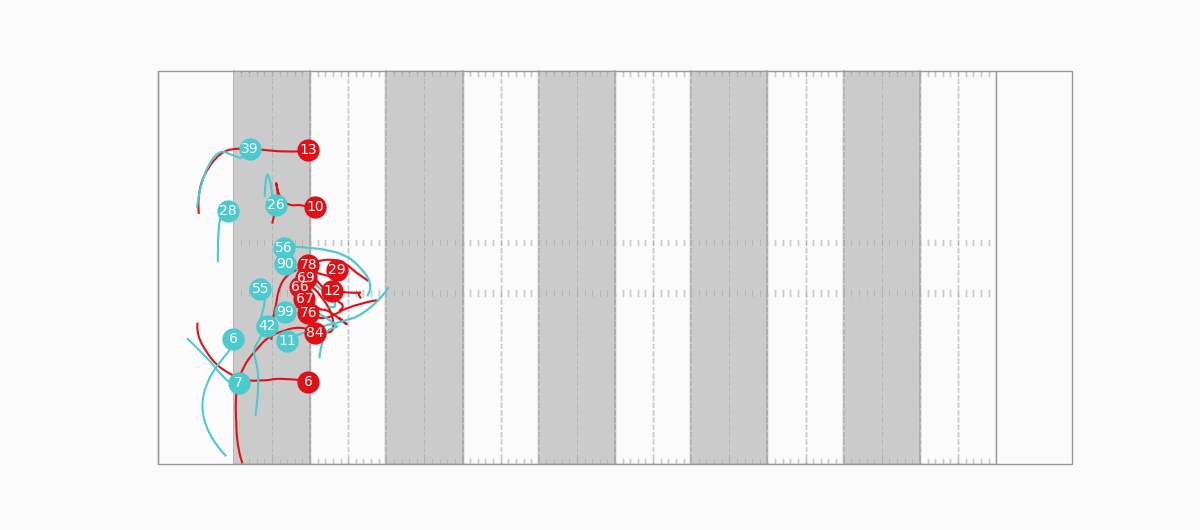

In [ ]:
Image(open('tracking_play.gif','rb').read())

That concludes our brief introduction to our tracking data.

We look forward to seeing what you can come up with!